# Test case C: Learning the layout from the criterion evaluation for each row

In [1]:
import jax
import jax.numpy as jnp
from hybridoed.oed import *
import numpy as np
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [2]:
#TODO: fo a given Jacobian, evaluate the nRER for each block corresponding to a source

# load the jacobians
jacobians = jnp.load("curvel_jac_5_5_5.npy")

In [3]:
print(jacobians.shape)

transposed_jacobians = jnp.transpose(jacobians, axes=(1, 2, 0, 3))

print(transposed_jacobians.shape)


(5, 25, 25, 9800)
(25, 25, 5, 9800)


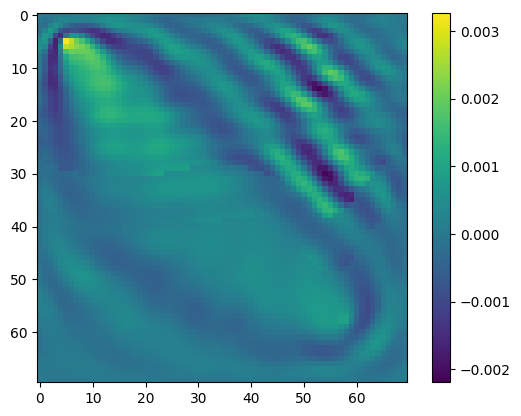

In [4]:
# plot the jacobians
plt.figure()
plt.imshow(jacobians[-1,0,-1,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

In [5]:
stacked_array = jnp.stack([array.reshape(-1, array.shape[-1]) for array in transposed_jacobians])
stacked_array.shape

(25, 125, 9800)

In [6]:
complex_stack_complete = []
for src in stacked_array:
    complex_stack = []
    for row in src:
        real_part = row.reshape(70,140)[:,:70]
        imaginary_part = row.reshape(70,140)[:,70:]
        complex_stack.append(real_part + 1j * imaginary_part)

    # Convert to NumPy array if needed
    complex_stack = jnp.array(complex_stack)

    # print(complex_stack.shape)

    # Flatten all rows into num_rows x 4900 matrix
    num_rows = complex_stack.shape[0]
    complex_reshaped = np.empty((num_rows, 4900), dtype=np.complex128)

    for i, complex_matrix in enumerate(complex_stack):
        complex_reshaped[i, :] = complex_matrix.flatten()
    
    complex_stack_complete.append(complex_reshaped)

complex_stack_complete = jnp.array(complex_stack_complete)
print(complex_stack_complete.shape)

complex_stack_complete_2D = jnp.vstack([array for array in complex_stack_complete])
print(complex_stack_complete_2D.shape)


(25, 125, 4900)
(3125, 4900)


In [7]:
params = {
    "criterion_threshold": 1e-2,
    "regularisation_loss": 0.0,
    "norm_loss": 0.03,
    "top_k_loss": 0.0,
    "differentiable_mask_sharpness": 10.0,
    "number_of_k":10,
    "hidden_size": 56,
    "num_hidden_layers": 3,
    "learning_rate": 1e-3,
    "num_iterations": 15,
    "print_gradients": False,
}

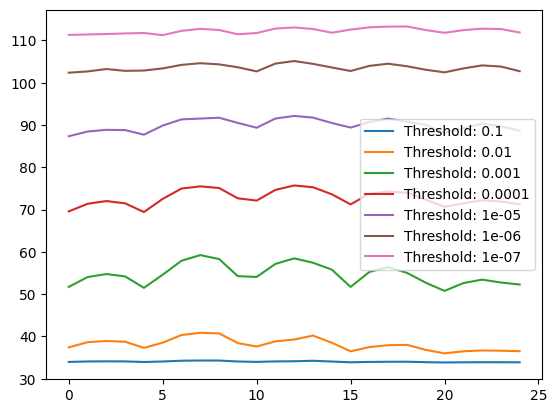

In [8]:
plt.figure()

threshold = [1e-1, 1e-2,1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
for th in threshold:
    C_sources = []
    for array in stacked_array:
        C_sources.append(eigenvalue_criterion(array, threshold=th))
    plt.plot(C_sources, label=f"Threshold: {th}")


plt.legend()
plt.show()

criterion_threshold = params["criterion_threshold"]

C_sources_1e_3 = [] 
for array in stacked_array:
    C_sources_1e_3.append(eigenvalue_criterion(array, threshold=criterion_threshold))

C_sources_1e_3 = jnp.array(C_sources_1e_3)

In [9]:
# Compute the singular values of the Jacobian and plot them
singular_values = jnp.sort(jnp.linalg.svdvals(complex_stack_complete_2D)**2)[::-1]



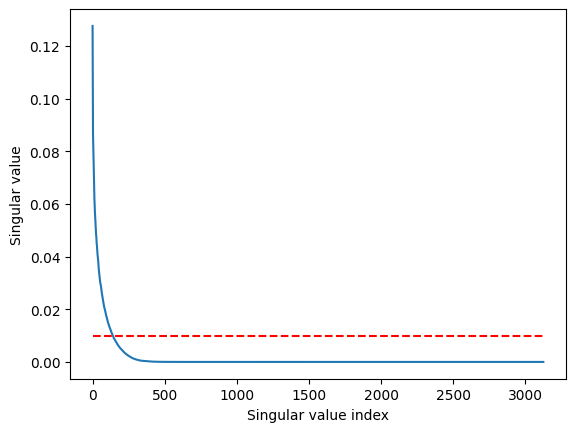

In [10]:
plt.figure()
plt.plot(singular_values)
# plt.semilogy(singular_values)
# plt.yscale('log')
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.hlines(criterion_threshold, 0, len(singular_values), colors='r', linestyles='dashed', label='Threshold')

plt.show()


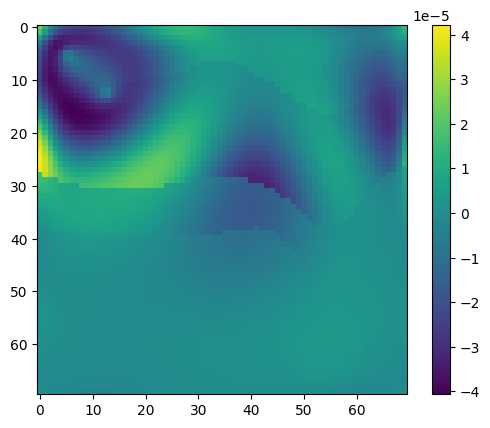

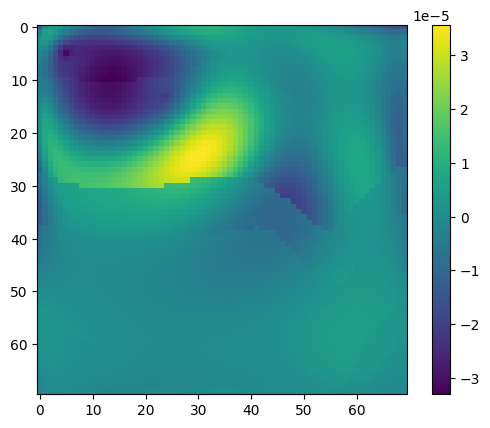

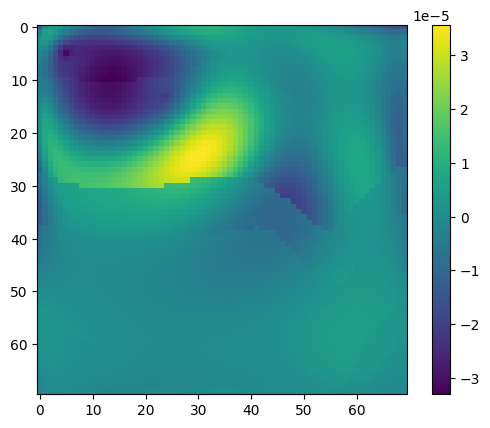

In [11]:
# plot the stacked array
plt.figure()
plt.imshow(stacked_array[0,0,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(stacked_array[0,5,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(jnp.real(complex_stack_complete[0,5,:].reshape(70,70)), cmap='viridis')
plt.colorbar()
plt.show()

In [12]:
# Fully Connected Neural Network
class FullyConnectedNN(eqx.Module):
    layers: list
    activations: list

    def __init__(self, input_size, hidden_size, num_hidden_layers, key):
        keys = jax.random.split(key, num_hidden_layers + 1)
        self.layers = [eqx.nn.Linear(input_size, hidden_size, key=keys[0])] + \
                      [eqx.nn.Linear(hidden_size, hidden_size, key=k) for k in keys[1:-1]] + \
                      [eqx.nn.Linear(hidden_size, input_size, key=keys[-1])]
        
        self.activations = [jax.nn.tanh] * num_hidden_layers + [jax.nn.sigmoid]

    def __call__(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

def top_k_regularization(soft_mask, k=10):
    top_k_values = jax.lax.top_k(soft_mask, k)[0]
    penalty = jnp.sum(soft_mask) - jnp.sum(top_k_values)
    return penalty

# Differentiable Loss Function
def differentiable_loss_fn(model, x, matrix, criterion_threshold ,sharpness=10.0, mask_penalty=0.1):
    probabilities = model(x)  # Predict probabilities
    soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    multiplier = matrix.shape[0] // soft_mask.shape[0]
    soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows

    regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    norm_loss = jnp.linalg.norm(soft_mask, ord=1)
    top_k_loss = top_k_regularization(soft_mask, k=params["number_of_k"])

    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)

    return -(singular_loss) + params["regularisation_loss"]*regularization_loss + params["norm_loss"]*norm_loss + params["top_k_loss"]*top_k_loss



In [13]:
# Example Usage
key = jax.random.PRNGKey(42)
input_size = C_sources_1e_3.shape[0]
hidden_size = params["hidden_size"]
num_hidden_layers = params["num_hidden_layers"]
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)

print("Model:", model)

# matrix = jax.random.normal(key, (100, 50))  # Matrix with 100 rows and 50 columns
matrix = complex_stack_complete_2D
# x = jax.random.normal(key, (input_size,))  # Input to the network
x = C_sources_1e_3
# x = (x - jnp.mean(x)) / jnp.std(x)
x = (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))




Model: FullyConnectedNN(
  layers=[
    Linear(
      weight=f32[56,25],
      bias=f32[56],
      in_features=25,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[25,56],
      bias=f32[25],
      in_features=56,
      out_features=25,
      use_bias=True
    )
  ],
  activations=[
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function sigmoid>
  ]
)


In [14]:
# loss = differentiable_loss_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)
# print("Loss:", loss)

# # Compute Gradients
# # grads = jax.grad(differentiable_loss_fn)(model, x, matrix, sharpness=10.0, mask_penalty=0.1)

# # Compute Gradients using equinox.filter_grad
# # grad_fn = eqx.filter_grad(differentiable_loss_fn)
# # grads = grad_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)

# loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
# loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)
# print("Loss:", loss)

Step 0, Loss: -822.9083251953125
Step 1, Loss: -823.521240234375
Step 2, Loss: -824.1972045898438
Step 3, Loss: -824.9420776367188
Step 4, Loss: -825.7582397460938
Step 5, Loss: -826.6472778320312
Step 6, Loss: -827.6095581054688
Step 7, Loss: -828.642822265625
Step 8, Loss: -829.7400512695312
Step 9, Loss: -830.890869140625
Step 10, Loss: -832.0830688476562
Step 11, Loss: -833.3031616210938
Step 12, Loss: -834.5374755859375
Step 13, Loss: -835.7725830078125
Step 14, Loss: -836.9949951171875


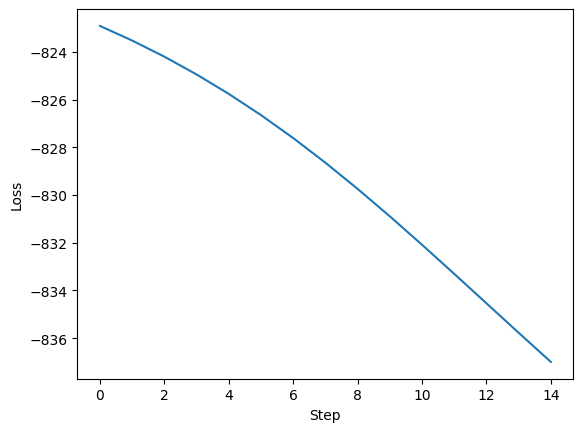

In [15]:
def train_step(model, matrix, criterion_threshold, optimizer, opt_state, x, logs):
    # Compute loss and gradients
    loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
    loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=criterion_threshold, sharpness=params["differentiable_mask_sharpness"], mask_penalty=1.0)
    
    if params["print_gradients"]:  
        jax.tree_util.tree_map(lambda g: print("Gradient shape:", g.shape, "Gradient values:", g), grads)
        jax.tree_util.tree_map(lambda g: print(f"Gradient shape: {g.shape}, Min: {jnp.min(g)}, Max: {jnp.max(g)}, Mean: {jnp.mean(g)}"), grads)

    # Update optimizer state and model
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)

    # Log the network output (predicted probabilities)
    probabilities = model(x)  # Network output
    logs["probabilities"].append(probabilities)

    # Log the mask M
    soft_mask = differentiable_mask(probabilities, sharpness=params["differentiable_mask_sharpness"])  # Differentiable mask
    logs["masks"].append(soft_mask)

    return loss, model, opt_state


# Initialize the model and optimizer
key = jax.random.PRNGKey(42)
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)
optimizer = optax.adamw(params["learning_rate"])  # Adam optimizer
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))  # Initialize optimizer state
initial_predictions = model(x)  # Initial predictions

# Training loop
num_steps = params["num_iterations"]
losses = []
logs = {"probabilities": [], "masks": []}
for step in range(num_steps):
    loss, model, opt_state = train_step(model, matrix, criterion_threshold, optimizer, opt_state, x, logs)
    losses.append(loss)

    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


Step 0: Probabilities: [0.554038   0.52584094 0.48759115 0.5388374  0.505158   0.5062507
 0.4934466  0.48982215 0.5035804  0.5187307  0.4995048  0.49398348
 0.5119842  0.57202613 0.54274094 0.47890323 0.5034457  0.487199
 0.5028646  0.50826627 0.46998763 0.4762316  0.506929   0.49649778
 0.4576867 ]
Step 0: Mask: [0.6319008  0.5642452  0.46901762 0.5958912  0.5128922  0.5156216
 0.48362237 0.47457734 0.50895005 0.54669034 0.49876198 0.48496318
 0.52992475 0.6726646  0.60525495 0.44745284 0.50861335 0.46804115
 0.507161   0.5206539  0.42552727 0.4408572  0.51731557 0.49124536
 0.39576727]
Step 1: Probabilities: [0.5538808  0.53396845 0.48609006 0.5492705  0.50905365 0.51265705
 0.4989826  0.49957752 0.5160667  0.5239889  0.50242406 0.49797672
 0.5214598  0.583651   0.54568875 0.47532985 0.49910846 0.48859003
 0.5081486  0.5080961  0.45885566 0.474299   0.50472176 0.49095613
 0.4502118 ]
Step 1: Mask: [0.6315351  0.5841139  0.4652811  0.62074345 0.52261865 0.5316004
 0.49745655 0.4989437

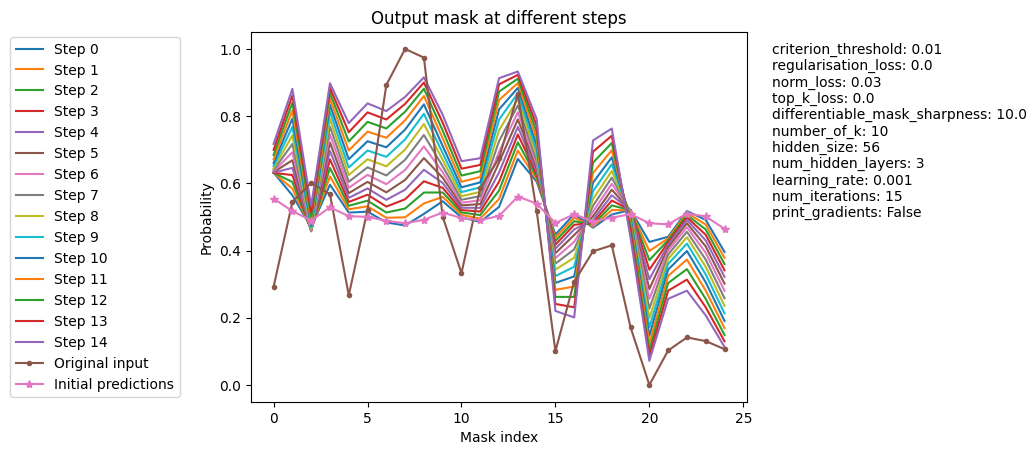

In [16]:
# Print the first few steps for inspection
for i, (probs, mask) in enumerate(zip(logs["probabilities"], logs["masks"])):
    print(f"Step {i}: Probabilities: {probs}")
    print(f"Step {i}: Mask: {mask}")
    if i > 5:  # Limit to first few steps for readability
        break

# Example: Plot the first mask at different training steps
steps_to_plot = [i for i in range(num_steps)]  # Select steps to visualize
plt.figure()

for step in steps_to_plot:
    plt.title(f"Output mask at different steps")
    plt.plot(logs["masks"][step], label=f"Step {step}")
    # plt.colorbar(label="Mask Values")
    plt.xlabel("Mask index")
    plt.ylabel("Probability")

plt.plot(x, ".-", label="Original input")
plt.plot(initial_predictions,"*-", label="Initial predictions")
# put the legend outside of the graph, to the left
plt.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))

# add the params dictionary to the plot, on the right, one key per line
plt.text(1.05, 0.5, '\n'.join([f"{key}: {value}" for key, value in params.items()]), transform=plt.gca().transAxes)

plt.show()

In [17]:
# final prediction witht he 10 best sources
final_mask = logs["masks"][-1]
print(final_mask)

# get the indices of the 10 best sources
best_sources = jnp.argsort(final_mask)[-10:]
print("best source index", best_sources)

# make a mask with the best sources
mask_best_sources = jnp.zeros_like(final_mask)
mask_best_sources = mask_best_sources.at[best_sources].set(1.0)

print(mask_best_sources, "sum:", jnp.sum(mask_best_sources))



multiplier = matrix.shape[0] // mask_best_sources.shape[0]
full_mask = jnp.repeat(mask_best_sources, multiplier, axis=0)

weighted_matrix = full_mask[:, None] * matrix  # Apply mask to matrix rows

singular_loss = eigenvalue_criterion(weighted_matrix, threshold=params["criterion_threshold"])
print("Singular loss:", singular_loss)



[0.7172143  0.8811222  0.53275615 0.89775926 0.7791564  0.8378876
 0.8151086  0.85717607 0.91536987 0.803996   0.66595113 0.67464083
 0.9128181  0.93283516 0.79179716 0.22016859 0.20088467 0.7275738
 0.7630931  0.43787363 0.07197201 0.25618938 0.28052315 0.20677018
 0.11305676]
best source index [14  9  6  5  7  1  3 12  8 13]


[0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] sum: 10.0
Singular loss: 890.8608


In [18]:
# mask from test case A

# best_source_A = jnp.array([10, 21, 20, 22, 23, 24, 19, 16, 15, 17])
# best_source_A = jnp.array([5, 20, 23, 24, 21, 22, 19, 16, 15, 17])
best_source_A = jnp.array([21, 22, 20, 23, 24, 16, 17, 15, 18, 19])

print("best source index A", best_source_A)

# make a mask with the best sources
mask_best_source_A = jnp.zeros_like(final_mask)
mask_best_source_A = mask_best_source_A.at[best_source_A].set(1.0)
print(mask_best_source_A, "sum:", jnp.sum(mask_best_source_A))

multiplier = matrix.shape[0] // mask_best_source_A.shape[0]
full_mask = jnp.repeat(mask_best_source_A, multiplier, axis=0)

weighted_matrix = full_mask[:, None] * matrix  # Apply mask to matrix rows

singular_loss = eigenvalue_criterion(weighted_matrix, threshold=params["criterion_threshold"])
print("Singular loss:", singular_loss)

best source index A [21 22 20 23 24 16 17 15 18 19]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.] sum: 10.0
Singular loss: 871.2674


In [19]:
# random selection of sources

# number_of_random_realisations = 100
# loss_random = []

# for i in range(number_of_random_realisations):
#     best_source_A = jnp.array(np.random.choice(jnp.arange(0, 25), 10, replace=False))

#     mask_best_source_A = jnp.zeros_like(final_mask)
#     mask_best_source_A = mask_best_source_A.at[best_source_A].set(1.0)
#     if jnp.sum(mask_best_source_A) != 10:
#         print("Error in mask")
#         break

#     multiplier = matrix.shape[0] // mask_best_source_A.shape[0]
#     full_mask = jnp.repeat(mask_best_source_A, multiplier, axis=0)

#     weighted_matrix = full_mask[:, None] * matrix  # Apply mask to matrix rows

#     singular_loss = eigenvalue_criterion(weighted_matrix, threshold=params["criterion_threshold"])
#     loss_random.append(singular_loss)


# loss_random = jnp.array(loss_random)

# plt.figure()
# plt.hist(loss_random, bins=20)
# plt.show()


# print("Mean loss:", jnp.mean(loss_random))
# print("Std loss:", jnp.std(loss_random))
# print("Min loss:", jnp.min(loss_random))
# print("Max loss:", jnp.max(loss_random))
# print("Median loss:", jnp.median(loss_random))



In [20]:
Comprehensive_criterion = eigenvalue_criterion(matrix, threshold=params["criterion_threshold"])
print("Comprehensive loss:", Comprehensive_criterion)

Comprehensive loss: 929.16644
